In [1]:
!pip install --upgrade --force-reinstall numpy==1.26.4
!pip install --upgrade --force-reinstall tensorflow==2.17.1 tensorflow-datasets==4.9.4


  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompati

  Using cached tensorflow-2.17.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached tensorflow_datasets-4.9.4-py3-none-any.whl.metadata (9.2 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.14.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.7 kB)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached ml_dtypes-0.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached numpy-1.26.4-cp312-cp312

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
import os, math
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("TF:", tf.__version__)

# ---- Hyperparameters ----
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 256        # 128 or 256 for speed; raise later
BATCH    = 16
EPOCHS   = 38          # demo; raise for real training
LAMBDA   = 1e-3       # rate–distortion tradeoff (tune)
LATENT_CH = 96        # latent channels (controls bpp)
SEED = 42
tf.keras.utils.set_random_seed(SEED)


TF: 2.17.1


In [3]:
# CLIC comes with 'train' and 'validation'
ds, info = tfds.load("clic", with_info=True)
train_raw = ds["train"]
val_raw   = ds["validation"]
print(info)

tfds.core.DatasetInfo(
    name='clic',
    full_name='clic/1.0.0',
    description="""
    CLIC is a dataset for the Challenge on Learned Image Compression 2020 lossy
    image compression track. These images contain a mix of the professional and
    mobile datasets used to train and benchmark rate-distortion performance. The
    dataset contains both RGB and grayscale images. This may require special
    handling if a grayscale image is processed as a 1 channel Tensor and a 3 channel
    Tensor is expected.
    
    This dataset does *NOT* contain the data from the P-Frame challenge (YUV image
    frames).
    """,
    homepage='https://www.compression.cc/',
    data_dir='/root/tensorflow_datasets/clic/1.0.0',
    file_format=tfrecord,
    download_size=7.48 GiB,
    dataset_size=7.48 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
    }),
    supervised_keys=None,
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_ex

In [4]:
def to_float01(x):
    return tf.image.convert_image_dtype(x, tf.float32)

def degrade_iot(x):
    # light IoT-like noise + blur (can disable for clean training)
    noise = tf.random.normal(tf.shape(x), stddev=0.01, seed=SEED)
    x = x + noise
    x = tf.nn.avg_pool2d(x[None, ...], ksize=2, strides=1, padding='SAME')[0]
    return tf.clip_by_value(x, 0.0, 1.0)

def center_square_resize(x, size):
    h = tf.shape(x)[0]; w = tf.shape(x)[1]
    s = tf.minimum(h, w)
    x = tf.image.resize_with_crop_or_pad(x, s, s)
    x = tf.image.resize(x, (size, size), antialias=True)
    return x

def preprocess_train(img):
    img = to_float01(img['image'])
    img = center_square_resize(img, IMG_SIZE)
    img = degrade_iot(img)  # comment out this line if you want “clean” data
    return img, img

def preprocess_val(img):
    img = to_float01(img['image'])
    img = center_square_resize(img, IMG_SIZE)
    return img, img

train = (train_raw
         .map(preprocess_train, num_parallel_calls=AUTOTUNE)
         .shuffle(2048, seed=SEED, reshuffle_each_iteration=True)
         .batch(BATCH)
         .prefetch(AUTOTUNE))

val = (val_raw
       .map(preprocess_val, num_parallel_calls=AUTOTUNE)
       .batch(BATCH)
       .prefetch(AUTOTUNE))

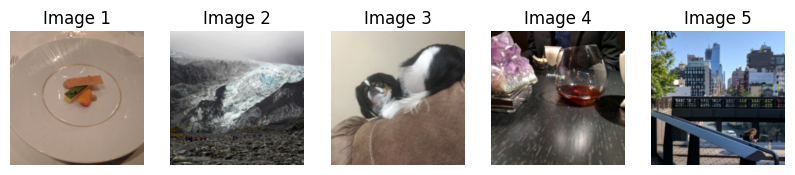

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage.metrics import structural_similarity as ssim

sample_images = next(iter(train.take(10)))  # Take 10 samples
sample_images = sample_images[0].numpy()  # Extract only images

# 1. Display random sample images
def plot_random_images(images, n=5):
    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.show()

plot_random_images(sample_images)

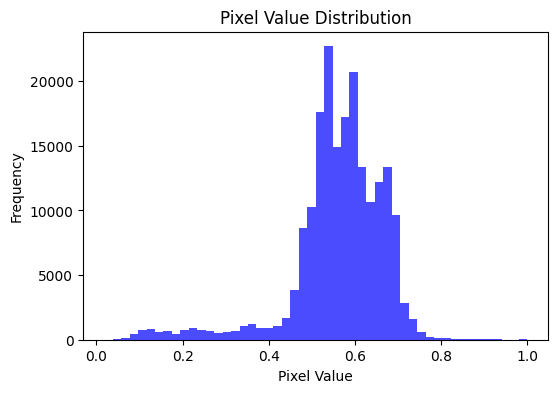

In [8]:
def plot_pixel_distribution(image):
    plt.figure(figsize=(6, 4))
    plt.hist(image.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('Pixel Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

plot_pixel_distribution(sample_images[0])


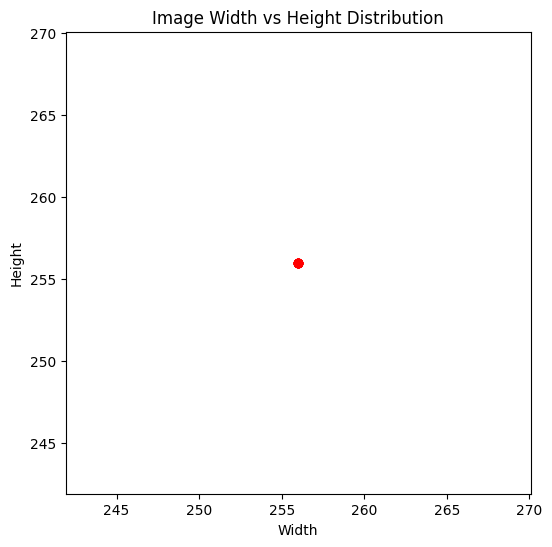

In [9]:
image_sizes = [img.shape[:2] for img in sample_images]  # (height, width)
heights, widths = zip(*image_sizes)

plt.figure(figsize=(6, 6))
plt.scatter(widths, heights, color='red', alpha=0.6)
plt.title('Image Width vs Height Distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


In [19]:
import numpy as np

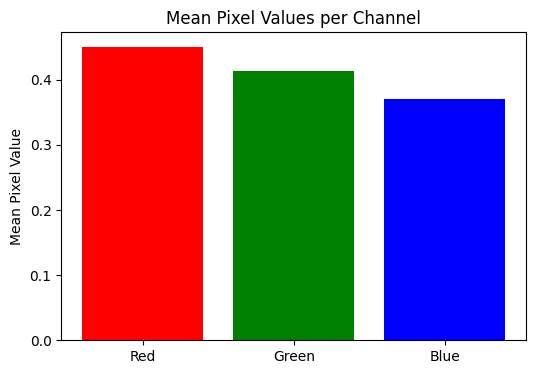

In [20]:
mean_pixel_values = np.mean(sample_images, axis=(0, 1, 2))

plt.figure(figsize=(6, 4))
plt.bar(['Red', 'Green', 'Blue'], mean_pixel_values, color=['red', 'green', 'blue'])
plt.title('Mean Pixel Values per Channel')
plt.ylabel('Mean Pixel Value')
plt.show()


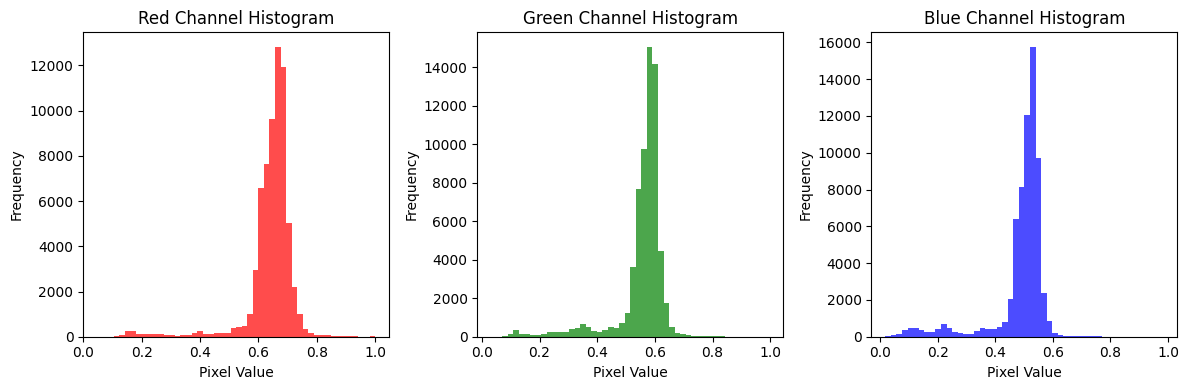

In [11]:
def plot_histogram_by_channel(image):
    plt.figure(figsize=(12, 4))
    for i, color in enumerate(['red', 'green', 'blue']):
        plt.subplot(1, 3, i+1)
        plt.hist(image[..., i].flatten(), bins=50, color=color, alpha=0.7)
        plt.title(f'{color.capitalize()} Channel Histogram')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_histogram_by_channel(sample_images[0])


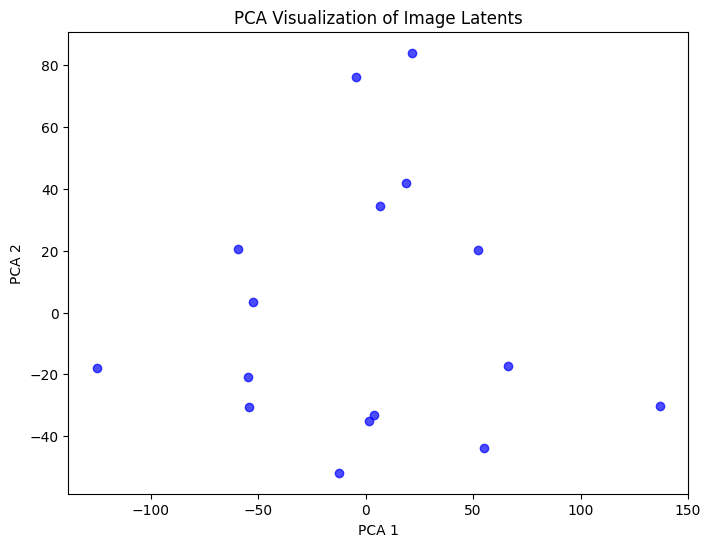

In [21]:
def plot_pca(images, n_components=2):
    flattened_images = np.array([img.flatten() for img in images])
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(flattened_images)

    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], color='blue', alpha=0.7)
    plt.title('PCA Visualization of Image Latents')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

plot_pca(sample_images)

In [22]:
def plot_tsne(images):
    flattened_images = np.array([img.flatten() for img in images])
    tsne = TSNE(n_components=2)
    tsne_result = tsne.fit_transform(flattened_images)

    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], color='green', alpha=0.7)
    plt.title('t-SNE Visualization of Image Latents')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

plot_tsne(sample_images)

ValueError: perplexity must be less than n_samples

In [24]:
import cv2

In [25]:
def plot_ssim(images):
    ssim_values = []
    for i in range(len(images) - 1):
        image1 = cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY)
        image2 = cv2.cvtColor(images[i + 1], cv2.COLOR_RGB2GRAY)
        ssim_val, _ = ssim(image1, image2, full=True)
        ssim_values.append(ssim_val)

    plt.figure(figsize=(6, 4))
    plt.plot(ssim_values, marker='o', linestyle='-', color='purple')
    plt.title('SSIM between Consecutive Images')
    plt.xlabel('Image Pair Index')
    plt.ylabel('SSIM Value')
    plt.show()

plot_ssim(sample_images)

ValueError: Since image dtype is floating point, you must specify the data_range parameter. Please read the documentation carefully (including the note). It is recommended that you always specify the data_range anyway.

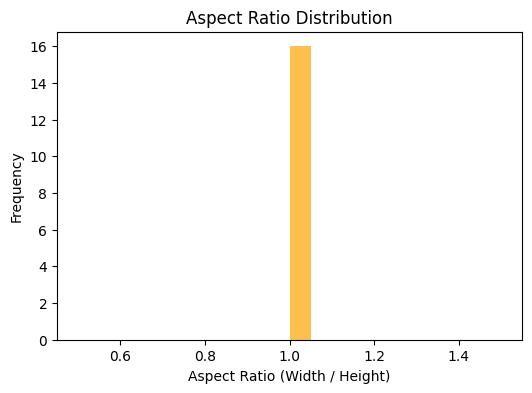

In [15]:
aspect_ratios = [width / height for width, height in image_sizes]

plt.figure(figsize=(6, 4))
plt.hist(aspect_ratios, bins=20, color='orange', alpha=0.7)
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Frequency')
plt.show()

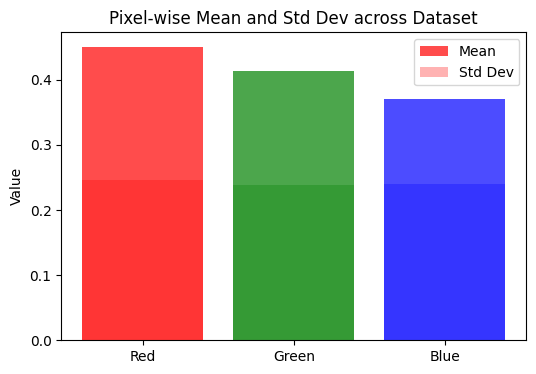

In [26]:
mean_pixels = np.mean(np.array([img for img in sample_images]), axis=(0, 1, 2))
std_pixels = np.std(np.array([img for img in sample_images]), axis=(0, 1, 2))

plt.figure(figsize=(6, 4))
plt.bar(['Red', 'Green', 'Blue'], mean_pixels, alpha=0.7, color=['red', 'green', 'blue'], label='Mean')
plt.bar(['Red', 'Green', 'Blue'], std_pixels, alpha=0.3, color=['red', 'green', 'blue'], label='Std Dev')
plt.title('Pixel-wise Mean and Std Dev across Dataset')
plt.legend()
plt.ylabel('Value')
plt.show()

In [28]:
import seaborn as sns

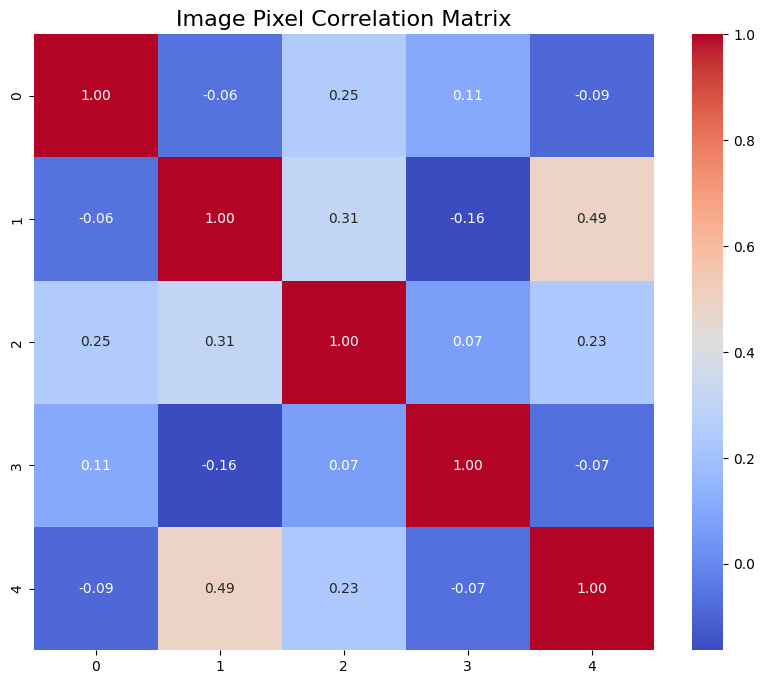

In [31]:
def plot_image_correlation(images):
    # Flatten images and compute correlation
    flattened_images = np.array([img.flatten() for img in images])
    corr_matrix = np.corrcoef(flattened_images)

    # Plot the correlation matrix with annotations
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', cbar=True)
    plt.title("Image Pixel Correlation Matrix", fontsize=16)
    plt.show()

# Using the first 5 images from the dataset
plot_image_correlation(sample_images[:5])


In [30]:
def plot_color_channel_correlation(images):
    red_channel = [img[..., 0].flatten() for img in images]
    green_channel = [img[..., 1].flatten() for img in images]
    blue_channel = [img[..., 2].flatten() for img in images]

    # Concatenate all channels
    data = np.array([red_channel, green_channel, blue_channel])
    corr_matrix = np.corrcoef(data)

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=['Red', 'Green', 'Blue'], yticklabels=['Red', 'Green', 'Blue'])
    plt.title("Color Channel Correlation")
    plt.show()

plot_color_channel_correlation(sample_images[:5])


ValueError: m has more than 2 dimensions

In [5]:
from tensorflow.keras import layers, models

class CayleyOrthogonal1x1(layers.Layer):
    def __init__(self, channels, eps=1e-4, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.eps = eps

    def build(self, input_shape):
        C = self.channels
        self.M = self.add_weight(name="M", shape=(C, C), initializer="zeros", trainable=True)
        super().build(input_shape)

    def call(self, x):
        C = self.channels
        A = self.M - tf.transpose(self.M)
        I = tf.eye(C, dtype=x.dtype)
        # Regularize the solve for stability: (I + A + eps*I)
        W = tf.linalg.solve(I + A + self.eps * I, I - A)
        return tf.tensordot(x, W, axes=[[3], [0]])



class STEBinarizer(tf.keras.layers.Layer):
    def __init__(self, superposition=False, noise_std=0.0, **kwargs):
        super().__init__(**kwargs)
        self.superposition = superposition
        self.noise_std = noise_std  # set >0.0 if you want latent noise during training

    def call(self, inputs, training=None):
        # Probabilities used for the entropy proxy
        probs = tf.sigmoid(inputs)  # in (0,1)

        if self.superposition:
            # Soft/superposition + straight-through rounding
            hard = tf.round(probs)
            codes = probs + tf.stop_gradient(hard - probs)
        else:
            # Classic STE with sign
            forward = tf.sign(inputs)
            codes = inputs + tf.stop_gradient(forward - inputs)

        # Optional stochasticity during training (quantum-style uncertainty)
        if training and self.noise_std > 0.0:
            codes = codes + tf.random.normal(tf.shape(codes), stddev=self.noise_std)

        # IMPORTANT: always return (codes, probs) in both train and test
        return codes, probs




In [6]:
def make_encoder(img_size=IMG_SIZE, latent_ch=LATENT_CH):
    inp = layers.Input(shape=(img_size, img_size, 3))
    x = layers.Conv2D(64, 5, strides=2, padding="same", activation="relu")(inp)    # 1/2
    x = layers.Conv2D(128, 5, strides=2, padding="same", activation="relu")(x)     # 1/4
    x = layers.Conv2D(192, 3, strides=2, padding="same", activation="relu")(x)     # 1/8
    x = layers.Conv2D(latent_ch, 1, padding="same")(x)                              # logits
    x = CayleyOrthogonal1x1(latent_ch)(x)                                          # unitary mix

    bits, probs = STEBinarizer(superposition=True, noise_std=0.0)(x)  # no training=... here
    return models.Model(inp, [bits, probs], name="encoder")



def make_decoder(img_size=IMG_SIZE, latent_ch=LATENT_CH):
    inp = layers.Input(shape=(img_size//8, img_size//8, latent_ch))
    x = layers.Conv2DTranspose(192, 3, strides=2, padding="same", activation="relu")(inp) # 1/4
    x = layers.Conv2DTranspose(128, 5, strides=2, padding="same", activation="relu")(x)   # 1/2
    x = layers.Conv2DTranspose(64,  5, strides=2, padding="same", activation="relu")(x)   # 1
    out = layers.Conv2D(3, 3, padding="same", activation="sigmoid")(x)
    return models.Model(inp, out, name="decoder")


# Build encoder/decoder
encoder = make_encoder(IMG_SIZE, LATENT_CH)
decoder = make_decoder(IMG_SIZE, LATENT_CH)

# Graph model (summary only)
inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
bits, probs = encoder(inp, training=True)   # ensure (bits, probs) in training
recon = decoder(bits)
quibc_graph = models.Model(inp, recon, name="QUIBC_graph")
quibc_graph.summary()

Model: "QUIBC_graph"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 32, 32, 96),   │       458,912 │
│                                 │ (None, 32, 32, 96)]    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 256, 256, 3)    │       987,203 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,446,115 (5.52 MB)

 Trainable params: 1,446,115 (5.52 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
mse_loss = tf.keras.losses.MeanSquaredError()

def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ms_ssim_metric(y_true, y_pred):
    return tf.image.ssim_multiscale(y_true, y_pred, max_val=1.0)

def entropy_bits(p, eps=1e-9):
    """
    Shannon entropy in bits: H(p) = -p log2 p - (1-p) log2 (1-p).
    p comes from STEBinarizer (probabilities of bit=1).
    """
    p = tf.clip_by_value(p, eps, 1.0 - eps)
    H = -(p * tf.math.log(p) + (1.0 - p) * tf.math.log(1.0 - p)) / tf.math.log(2.0)
    return tf.reduce_mean(H)   # averaged entropy in bits

In [8]:
class QUIBCModel(tf.keras.Model):
    def __init__(self, encoder, decoder, lam=LAMBDA):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        # Initial λ (used as starting point)
        self.lam = lam

        # Learnable λ parameter (positive by construction)
        self.lambda_param = tf.Variable(
            tf.math.log(float(lam)), trainable=True, dtype=tf.float32, name="adaptive_lambda"
        )

        # Metrics
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.psnr_tracker = tf.keras.metrics.Mean(name="psnr")
        self.msssim_tracker = tf.keras.metrics.Mean(name="ms_ssim")
        self.rate_tracker = tf.keras.metrics.Mean(name="rate_bits")

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_tracker, self.msssim_tracker, self.rate_tracker]

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            bits, probs = self.encoder(x, training=True)
            yhat = self.decoder(bits, training=True)

            # Distortion term
            d = mse_loss(y, yhat)

            # Rate term
            r = entropy_bits(probs)

            # Adaptive λ: ensure positivity using softplus
            lam_eff = tf.nn.softplus(self.lambda_param)

            # Rate–distortion loss
            loss = d + lam_eff * r

        vars_ = self.encoder.trainable_variables + self.decoder.trainable_variables + [self.lambda_param]
        grads = tape.gradient(loss, vars_)
        self.optimizer.apply_gradients(zip(grads, vars_))

        # Metrics
        self.loss_tracker.update_state(loss)
        self.psnr_tracker.update_state(tf.reduce_mean(psnr_metric(y, yhat)))
        self.msssim_tracker.update_state(tf.reduce_mean(ms_ssim_metric(y, yhat)))
        self.rate_tracker.update_state(r)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data
        bits, probs = self.encoder(x, training=False)
        yhat = self.decoder(bits, training=False)

        d = mse_loss(y, yhat)
        r = entropy_bits(probs)

        lam_eff = tf.nn.softplus(self.lambda_param)
        loss = d + lam_eff * r

        self.loss_tracker.update_state(loss)
        self.psnr_tracker.update_state(tf.reduce_mean(psnr_metric(y, yhat)))
        self.msssim_tracker.update_state(tf.reduce_mean(ms_ssim_metric(y, yhat)))
        self.rate_tracker.update_state(r)

        return {m.name: m.result() for m in self.metrics}


# Instantiate and compile
quibc = QUIBCModel(encoder, decoder, lam=LAMBDA)
quibc.compile(optimizer=tf.keras.optimizers.Adam(1e-4))


In [9]:
import tensorflow as tf
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [10]:
import numpy as np
from sklearn.model_selection import KFold

# --- Convert tf.data.Dataset to numpy subset (limited size) ---
def dataset_to_numpy(ds, limit=300):
    xs = []
    for i, (x, _) in enumerate(ds.unbatch().take(limit)):
        xs.append(x.numpy())
    return np.array(xs)

# Take a subset of train/val to avoid RAM crash
X_train = dataset_to_numpy(train, limit=300)
X_val   = dataset_to_numpy(val, limit=100)
X_all   = np.concatenate([X_train, X_val], axis=0)

print("✅ Subset ready for CV:", X_all.shape)

# --- Cross-validation ---
k = 3   # 3 folds for speed
kf = KFold(n_splits=k, shuffle=True, random_state=SEED)

psnr_scores, ssim_scores, bpp_scores = [], [], []

fold = 1
for train_index, val_index in kf.split(X_all):
    print(f"\n🔹 Fold {fold}/{k} ...")

    # Split data for this fold
    X_tr, X_va = X_all[train_index], X_all[val_index]

    # Convert to tf.data.Dataset
    train_ds = tf.data.Dataset.from_tensor_slices((X_tr, X_tr)).batch(BATCH).prefetch(AUTOTUNE)
    val_ds   = tf.data.Dataset.from_tensor_slices((X_va, X_va)).batch(BATCH).prefetch(AUTOTUNE)

    # Fresh model each fold
    encoder = make_encoder(IMG_SIZE, LATENT_CH)
    decoder = make_decoder(IMG_SIZE, LATENT_CH)
    quibc   = QUIBCModel(encoder, decoder, lam=LAMBDA)
    quibc.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

    # Train quickly (use small epochs to avoid long runtime)
    quibc.fit(train_ds, epochs=5, validation_data=val_ds, verbose=1)

    # Evaluate
    results = quibc.evaluate(val_ds, return_dict=True, verbose=0)
    psnr_scores.append(results["psnr"])
    ssim_scores.append(results["ms_ssim"])
    bpp_scores.append(results["rate_bits"])

    print(f"Fold {fold} results: PSNR={results['psnr']:.2f}, MS-SSIM={results['ms_ssim']:.4f}, BPP={results['rate_bits']:.4f}")
    fold += 1

# --- Final summary ---
print("\n✅ Cross-Validation Summary:")
print(f"Average PSNR    : {np.mean(psnr_scores):.2f} ± {np.std(psnr_scores):.2f}")
print(f"Average MS-SSIM : {np.mean(ssim_scores):.4f} ± {np.std(ssim_scores):.4f}")
print(f"Average BPP     : {np.mean(bpp_scores):.4f} ± {np.std(bpp_scores):.4f}")


✅ Subset ready for CV: (400, 256, 256, 3)

🔹 Fold 1/3 ...
Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 353s 21s/step - loss: 0.0735 - ms_ssim: 0.2396 - psnr: 11.7292 - rate_bits: 0.9998 - val_loss: 0.0665 - val_ms_ssim: 0.3176 - val_psnr: 12.1941 - val_rate_bits: 0.9999
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 366s 20s/step - loss: 0.0616 - ms_ssim: 0.3100 - psnr: 12.5442 - rate_bits: 0.9989 - val_loss: 0.0652 - val_ms_ssim: 0.3143 - val_psnr: 12.2571 - val_rate_bits: 0.9945
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 387s 20s/step - loss: 0.0607 - ms_ssim: 0.3169 - psnr: 12.6019 - rate_bits: 0.9567 - val_loss: 0.0638 - val_ms_ssim: 0.3284 - val_psnr: 12.3243 - val_rate_bits: 0.8603
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 333s 20s/step - loss: 0.0567 - ms_ssim: 0.3446 - psnr: 12.9118 - rate_bits: 0.8092 - val_loss: 0.0570 - val_ms_ssim: 0.3741 - val_psnr: 12.8320 - val_rate_bits: 0.7914
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 343s 20s/step - loss: 0.0490 - ms_ssim: 0.4213 - psnr: 13.6620 - rate_bits: 0.8317 - 

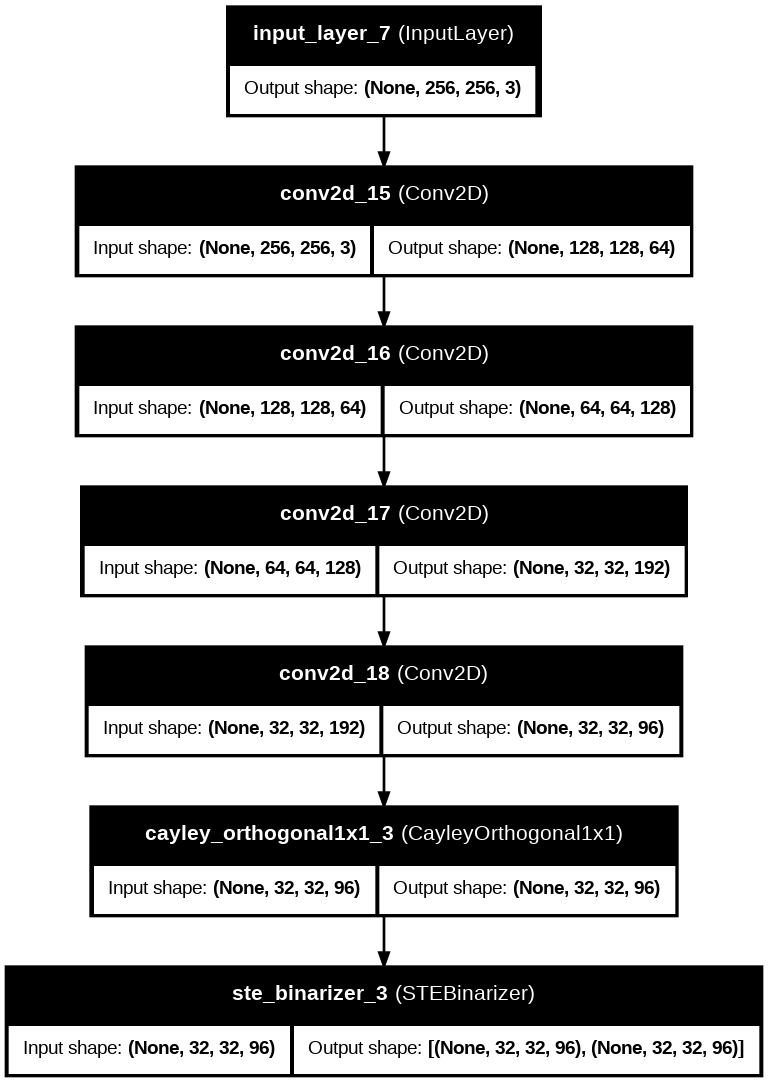

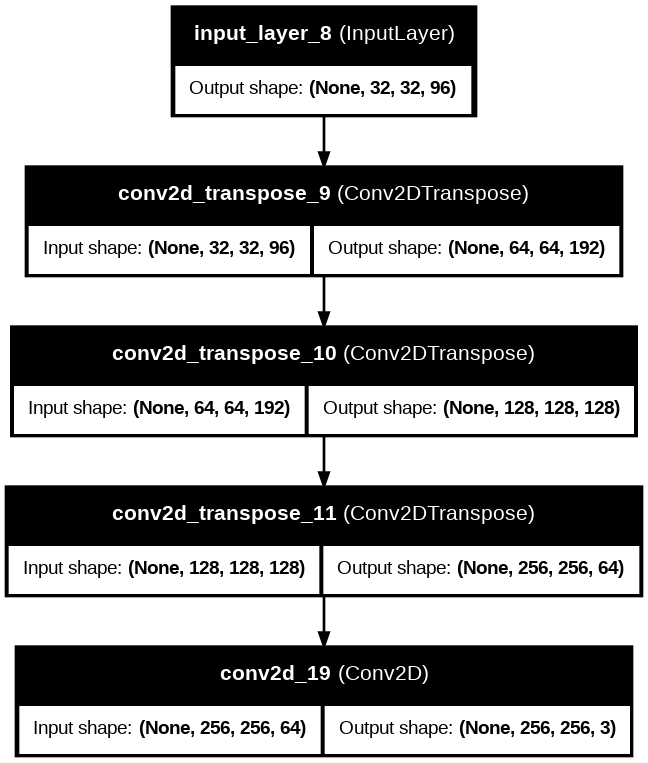

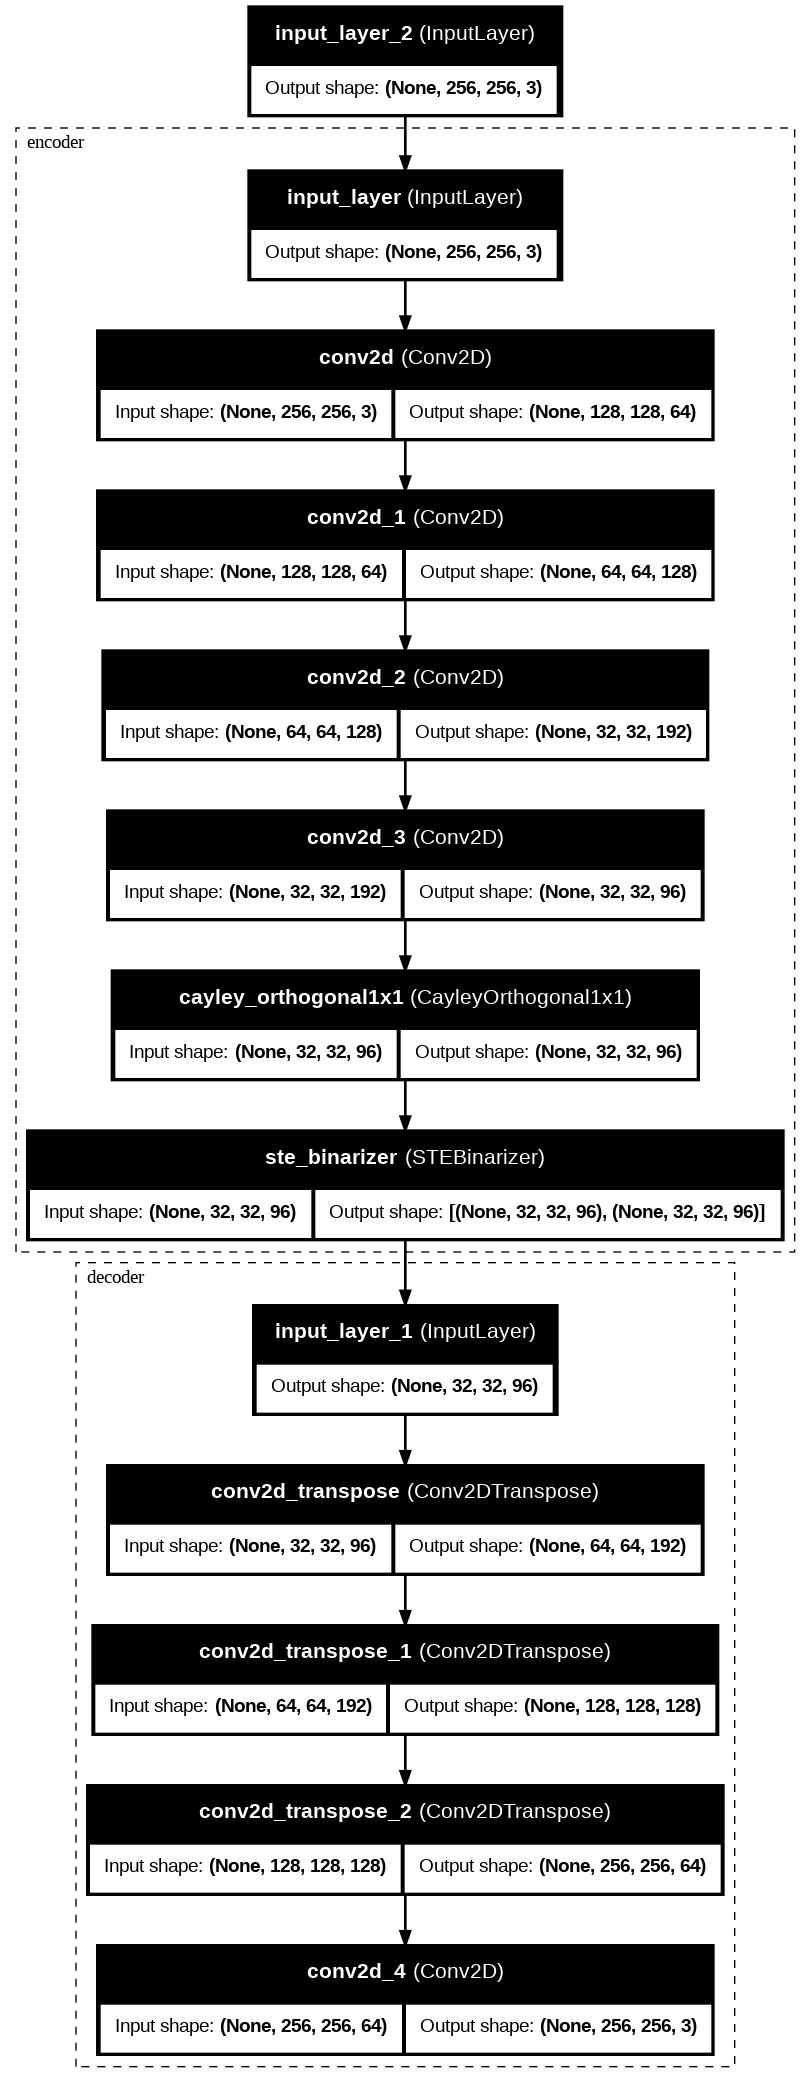

In [11]:
# ==============================
# Install dependencies in Colab
# ==============================
!apt-get -qq install graphviz
!pip install pydot

from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# ==============================
# Plot Encoder Graph
# ==============================
plot_model(
    encoder,
    to_file="encoder.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96
)
display(Image("encoder.png"))

# ==============================
# Plot Decoder Graph
# ==============================
plot_model(
    decoder,
    to_file="decoder.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96
)
display(Image("decoder.png"))

# ==============================
# Plot Full Autoencoder Graph
# ==============================
plot_model(
    quibc_graph,
    to_file="quibc_graph.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96
)
display(Image("quibc_graph.png"))


In [ ]:
history = quibc.fit(train, epochs=EPOCHS, validation_data=val)

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 4, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot PSNR
    plt.subplot(1, 4, 2)
    plt.plot(history.history['psnr'], label='train_psnr')
    plt.plot(history.history['val_psnr'], label='val_psnr')
    plt.title('PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.legend()
    plt.grid(True)

    # Plot MS-SSIM
    plt.subplot(1, 4, 3)
    plt.plot(history.history['ms_ssim'], label='train_ms_ssim')
    plt.plot(history.history['val_ms_ssim'], label='val_ms_ssim')
    plt.title('MS-SSIM')
    plt.xlabel('Epoch')
    plt.ylabel('MS-SSIM')
    plt.legend()
    plt.grid(True)

    # Plot Rate (bits)
    plt.subplot(1, 4, 4)
    plt.plot(history.history['rate_bits'], label='train_rate_bits')
    plt.plot(history.history['val_rate_bits'], label='val_rate_bits')
    plt.title('Rate (bits)')
    plt.xlabel('Epoch')
    plt.ylabel('Bits per pixel')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
# Cell 2: training curves
import matplotlib.pyplot as plt

# try to get history from variable `history` (Keras History) else build from metric logs if you saved them
if 'history' in globals() and hasattr(history, 'history'):
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)
    plt.figure(figsize=(14,8))
    plt.subplot(2,2,1); plt.plot(epochs, hist['loss'], label='train'); plt.plot(epochs, hist.get('val_loss',[]), label='val'); plt.title('Loss'); plt.legend()
    plt.subplot(2,2,2);
    if 'psnr' in hist: plt.plot(epochs, hist['psnr'], label='train')
    if 'val_psnr' in hist: plt.plot(epochs, hist['val_psnr'], label='val')
    plt.title('PSNR'); plt.legend()
    plt.subplot(2,2,3);
    if 'ms_ssim' in hist: plt.plot(epochs, hist['ms_ssim'], label='train')
    if 'val_ms_ssim' in hist: plt.plot(epochs, hist.get('val_ms_ssim',[]), label='val')
    plt.title('MS-SSIM'); plt.legend()
    plt.subplot(2,2,4);
    if 'rate_bits' in hist: plt.plot(epochs, hist['rate_bits'], label='train')
    if 'val_rate_bits' in hist: plt.plot(epochs, hist.get('val_rate_bits',[]), label='val')
    plt.title('Rate (bits/symbol avg)'); plt.legend()
    plt.tight_layout()
else:
    print("No Keras 'history' found. If you logged metrics externally, load them into `hist` dict with keys: loss, val_loss, psnr, val_psnr, ms_ssim, val_ms_ssim, rate_bits, val_rate_bits.")


In [ ]:
import numpy as np

def psnr_numpy(x, y, max_val=1.0):
    """Compute PSNR between two images (x, y) as numpy arrays."""
    mse = np.mean((x - y) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(max_val) - 10 * np.log10(mse)


In [ ]:
import numpy as np

def entropy_map_from_probs(probs, eps=1e-9):
    """
    Compute per-symbol entropy from probability maps.
    Args:
        probs: np.array of shape (..., num_symbols), probability distribution over symbols.
        eps: small value to avoid log(0).
    Returns:
        entropy_map: np.array of same batch/height/width, entropy (bits) per symbol.
    """
    probs = np.clip(probs, eps, 1.0)
    H = -np.sum(probs * np.log2(probs), axis=-1)  # entropy in bits
    return H


In [ ]:
# Cell 3: compute RD (bpp vs PSNR) on validation set
import numpy as np
def compute_rd(model, dataset, max_batches=None):
    psnrs = []; bpps = []; ms_ssims = []
    # Need IMG_SIZE and LATENT_CH from scope; adjust if different
    for i, (x, y) in enumerate(dataset):
        if (max_batches is not None) and (i >= max_batches):
            break
        # Run encoder to get bits & probs (or logits)
        # We handle both interfaces: if encoder returns (bits, probs) or logits
        enc_out = model.encoder(x, training=False)
        if isinstance(enc_out, (list, tuple)) and len(enc_out) == 2:
            bits, probs = enc_out
        else:
            bits = enc_out
            probs = None
        # decode
        yhat = model.decoder(bits, training=False)
        y_np = y.numpy()
        yhat_np = yhat.numpy()
        # per-sample PSNR
        for a, b in zip(y_np, yhat_np):
            psnrs.append(psnr_numpy(a, b))
            ms_ssims.append(tf.image.ssim_multiscale(a[None,...], b[None,...], max_val=1.0).numpy().item())
        # compute rate: if model exposes probs -> entropy map else fallback to global rate_tracker value
        if probs is not None:
            p_np = probs.numpy()
            H = entropy_map_from_probs(p_np)  # averaged bits per latent-symbol
            avg_bits_per_symbol = float(np.mean(H))
        else:
            # fallback: use model.rate_tracker if available
            try:
                avg_bits_per_symbol = float(model.rate_tracker.result().numpy())
            except:
                avg_bits_per_symbol = 1.0
        # latent spatial size and channels (assume bits shape)
        if isinstance(bits, tf.Tensor):
            bh, bw, bc = bits.shape[1], bits.shape[2], bits.shape[3]
        else:
            bh, bw, bc = IMG_SIZE//8, IMG_SIZE//8, LATENT_CH
        symbols_per_image = bh * bw * bc
        bpp_batch = avg_bits_per_symbol * symbols_per_image / (IMG_SIZE * IMG_SIZE)
        # append bpp for each sample in batch
        bpps.extend([bpp_batch] * bits.shape[0])
    return np.array(bpps), np.array(psnrs), np.array(ms_ssims)

bpp_vals, psnr_vals, msssim_vals = compute_rd(quibc, val, max_batches=50)  # limit for speed
# average RD point
print("Avg bpp:", bpp_vals.mean(), "Avg PSNR:", psnr_vals.mean())
# Plot scatter RD
plt.figure(figsize=(6,4)); plt.scatter(bpp_vals, psnr_vals, s=6); plt.xlabel('bpp'); plt.ylabel('PSNR (dB)'); plt.title('RD scatter (val subset)')
plt.grid(True); plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_image_grid(images, titles=None, rows=1, cols=None, figsize=(12, 8)):
    """
    Display a grid of images with optional titles.
    images: list of numpy arrays or tensors (H, W, C) or (H, W)
    titles: list of strings for each image
    rows, cols: grid dimensions. If cols is None, auto infer from rows.
    """
    n = len(images)
    if cols is None:
        cols = int(np.ceil(n / rows))
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i+1)
        if img.ndim == 3 and img.shape[-1] in [3,4]:
            plt.imshow(np.clip(img, 0, 1))  # assume float [0,1]
        else:
            plt.imshow(np.squeeze(img), cmap='gray')
        if titles and i < len(titles):
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

def show_image_grid(images, titles=None, rows=1, cols=None, figsize=(12, 4), **kwargs):
    """Display a grid of images with optional titles and extra imshow kwargs."""
    n = len(images)
    if cols is None:
        cols = int(np.ceil(n / rows))
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = np.array(axes).reshape(-1)
    for i, img in enumerate(images):
        ax = axes[i]
        if img.ndim == 2:  # grayscale/heatmap
            im = ax.imshow(img, **kwargs)
        else:  # RGB
            im = ax.imshow(img)
        ax.axis("off")
        if titles is not None:
            ax.set_title(titles[i], fontsize=10)
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
# Improved grid function (multi-row layout)
def show_image_grid(images, titles=None, ncols=3, cmap=None, figsize=(12, 8), vmin=None, vmax=None):
    n = len(images)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < n:
            if cmap:
                ax.imshow(images[i], cmap=cmap, vmin=vmin, vmax=vmax)
            else:
                ax.imshow(images[i])
            ax.axis("off")
            if titles is not None and i < len(titles):
                ax.set_title(titles[i], fontsize=10, pad=6, wrap=True)  # wrap avoids overlaps
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# -----------------------------
# Show original, reconstructions, diffs in 3 rows × n cols
show_image_grid(imgs, titles=titles, ncols=3, figsize=(12, 12))

# Show heatmaps in 1 row
show_image_grid(heatmaps, titles=[f'error map #{i}' for i in range(n)],
                ncols=n, cmap='magma', figsize=(14, 3), vmin=0, vmax=0.5)


In [ ]:
# Cell 5: entropy heatmaps
batch = next(iter(val))
x_batch, _ = batch
enc_out = quibc.encoder(x_batch[:8], training=False)
if isinstance(enc_out, (list,tuple)) and len(enc_out)==2:
    bits_sample, probs_sample = enc_out
else:
    probs_sample = None

if probs_sample is None:
    print("No 'probs' returned by encoder. Skipping entropy heatmaps.")
else:
    p_np = probs_sample.numpy()  # shape (B,H,W,C)
    avg_spatial_entropy = np.mean(entropy_map_from_probs(p_np), axis=-1)  # (B,H,W)
    # plot first 8 maps
    maps = [avg_spatial_entropy[i] for i in range(min(8, avg_spatial_entropy.shape[0]))]
    show_image_grid(maps, titles=[f'entropy #{i}' for i in range(len(maps))], cmap='inferno', figsize=(12,3))


In [ ]:
import numpy as np
from tensorflow.keras.models import Model

# Print all layers with their output shapes safely
for i, layer in enumerate(encoder.layers):
    try:
        print(i, layer.name, layer.output.shape)
    except:
        print(i, layer.name, "no output shape")

# Pick a convolutional layer index (replace with actual index from above printout)
conv_layer_index = 5   # <-- change based on your model
conv_layer = encoder.layers[conv_layer_index]

# Build intermediate model
intermediate_model = Model(inputs=encoder.input, outputs=conv_layer.output)

# Generate dummy input with correct size (same as model input)
input_shape = encoder.input.shape[1:]   # e.g., (256, 256, 3)
dummy_input = np.random.randn(1, *input_shape).astype(np.float32)

# Forward pass to get activations
activations = intermediate_model.predict(dummy_input)
print("Output shape (via forward pass):", activations.shape)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Print all layers with their output shapes safely
for i, layer in enumerate(encoder.layers):
    try:
        print(i, layer.name, layer.output.shape)
    except:
        print(i, layer.name, "no output shape")

# Pick a convolutional layer index (replace with actual index from above printout)
conv_layer_index = 5   # <-- adjust based on your earlier list
conv_layer = encoder.layers[conv_layer_index]

# Build intermediate model
intermediate_model = Model(inputs=encoder.input, outputs=conv_layer.output)

# Generate dummy input with correct size (same as model input)
input_shape = encoder.input.shape[1:]   # e.g., (256, 256, 3)
dummy_input = np.random.randn(1, *input_shape).astype(np.float32)

# Forward pass to get activations
activations = intermediate_model.predict(dummy_input)
print("Output shape (via forward pass):", activations.shape)

# --- Visualization ---
n_features = activations.shape[-1]          # number of feature maps
size = activations.shape[1]                 # spatial size (height/width)

# Plot first 16 feature maps for readability
n_cols = 8
n_rows = n_features // n_cols if n_features < 64 else 2   # limit rows
plt.figure(figsize=(20, 5))

for i in range(min(n_features, n_cols * n_rows)):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(activations[0, :, :, i], cmap="viridis")
    plt.axis("off")
    ax.set_title(f"Ch {i}", fontsize=8)

plt.suptitle(f"Feature maps from layer {conv_layer.name}", fontsize=14)
plt.show()


In [ ]:
from sklearn.manifold import TSNE


In [ ]:
# Cell 7: t-SNE of pooled latent vectors
N = 200  # total image samples to collect (may take time)
pooled = []
psnrs = []
count = 0
for x_batch, y_batch in val:
    enc_out = quibc.encoder(x_batch, training=False)
    if isinstance(enc_out, (list,tuple)) and len(enc_out)==2:
        bits_batch, _ = enc_out
    else:
        bits_batch = enc_out
    bits_np = bits_batch.numpy()  # (B,H,W,C)
    # spatial pooling (global average) -> vector per image
    v = bits_np.mean(axis=(1,2))  # (B,C)
    for i in range(v.shape[0]):
        pooled.append(v[i])
        psnrs.append(psnr_numpy(y_batch[i].numpy(), quibc.decoder(bits_batch[i:i+1], training=False).numpy()[0]))
        count += 1
        if count >= N: break
    if count >= N: break

pooled = np.stack(pooled)
tsne = TSNE(n_components=2, perplexity=30, random_state=SEED, init='pca', n_iter=1000)
proj = tsne.fit_transform(pooled)
plt.figure(figsize=(6,5))
plt.scatter(proj[:,0], proj[:,1], c=psnrs, cmap='viridis', s=8)
plt.colorbar(label='PSNR'); plt.title('t-SNE of pooled latents colored by PSNR'); plt.show()


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

# Histogram
axs[0].hist(psnrs, bins=20)
axs[0].set_title("PSNR histogram (val subset)")
axs[0].set_xlabel("PSNR (dB)")
axs[0].set_ylabel("Count")

# Cumulative distribution
axs[1].hist(psnrs, bins=20, cumulative=True, density=True)
axs[1].set_title("PSNR CDF (val subset)")
axs[1].set_xlabel("PSNR (dB)")
axs[1].set_ylabel("Cumulative fraction")

plt.tight_layout()
plt.show()


In [ ]:
# Cell 8: PSNR distribution
import pandas as pd
# reuse bpp_vals, psnr_vals from Cell 3 if available; else compute with small subset
if 'bpp_vals' not in globals():
    bpp_vals, psnr_vals, _ = compute_rd(quibc, val, max_batches=40)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(psnr_vals, bins=30); plt.title('PSNR histogram (val subset)'); plt.xlabel('PSNR (dB)')
plt.subplot(1,2,2)
# Boxplot PSNR by bpp quantiles
df = pd.DataFrame({'bpp': bpp_vals, 'psnr': psnr_vals})
df['bpp_q'] = pd.qcut(df['bpp'], q=4, labels=False)
df.boxplot(column='psnr', by='bpp_q', grid=False)
plt.suptitle(''); plt.title('PSNR by bpp quartiles')
plt.show()
